## DBSCAN for Detecting Financial Anomalies on Full Data

In [1]:
# Import the package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

In [2]:
# Columns to keep
columns = ['amtdb',
 'category',
 'subcategory',
 'fdb_commonname',
 'amtcr',
 'brnid',
 'brnmisc7',
 'altdept',
 'amtbalance',
 'date',
 'department',
 'type',
 'typ_text',]

In [3]:
# Read the file
df = pd.read_excel("~/Desktop/Data/df.xlsx", usecols=columns)
df.head(5)

,brnid,date,type,amtdb,amtcr,amtbalance,department,altdept,typ_text,category,subcategory,fdb_commonname,brnmisc7
0,200,45382,Expense,0.0,10.000000,-10.000000,Corporate,Used Truck Sales,Expense,Personnel,Employee Benefits,Employee Benefits,Corporate LATC
1,200,45351,Expense,10.0,0.000000,10.000000,Corporate,Used Truck Sales,Expense,Personnel,Employee Benefits,Employee Benefits,Corporate LATC
2,200,45504,Expense,0.0,155.000000,-155.000000,Corporate,Used Truck Sales,Expense,Personnel,Employee Benefits,Employee Benefits,Corporate LATC
3,200,45382,Expense,0.0,853.549988,-853.549988,Corporate,Used Truck Sales,Expense,Personnel,Employee Benefits,Employee Benefits,Corporate LATC
4,200,45504,Expense,0.0,900.000000,-900.000000,Corporate,Used Truck Sales,Expense,Personnel,Employee Benefits,Employee Benefits,Corporate LATC


In [4]:
# Convert column date into the dates
df['date'] = pd.to_datetime(df['date'], origin='1899-12-30', unit='D')
df.head(5)

,brnid,date,type,amtdb,amtcr,amtbalance,department,altdept,typ_text,category,subcategory,fdb_commonname,brnmisc7
0,200,2024-03-31,Expense,0.0,10.000000,-10.000000,Corporate,Used Truck Sales,Expense,Personnel,Employee Benefits,Employee Benefits,Corporate LATC
1,200,2024-02-29,Expense,10.0,0.000000,10.000000,Corporate,Used Truck Sales,Expense,Personnel,Employee Benefits,Employee Benefits,Corporate LATC
2,200,2024-07-31,Expense,0.0,155.000000,-155.000000,Corporate,Used Truck Sales,Expense,Personnel,Employee Benefits,Employee Benefits,Corporate LATC
3,200,2024-03-31,Expense,0.0,853.549988,-853.549988,Corporate,Used Truck Sales,Expense,Personnel,Employee Benefits,Employee Benefits,Corporate LATC
4,200,2024-07-31,Expense,0.0,900.000000,-900.000000,Corporate,Used Truck Sales,Expense,Personnel,Employee Benefits,Employee Benefits,Corporate LATC


In [5]:
# Create columns for year and month from the date column
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [6]:
# drop July 2024 data because it is incomplete
df = df.drop(df[(df['year'] == 2024) & (df['month'] == 7)].index)
df.head(5)

,brnid,date,type,amtdb,amtcr,amtbalance,department,altdept,typ_text,category,subcategory,fdb_commonname,brnmisc7,year,month
0,200,2024-03-31,Expense,0.0,10.000000,-10.000000,Corporate,Used Truck Sales,Expense,Personnel,Employee Benefits,Employee Benefits,Corporate LATC,2024,3
1,200,2024-02-29,Expense,10.0,0.000000,10.000000,Corporate,Used Truck Sales,Expense,Personnel,Employee Benefits,Employee Benefits,Corporate LATC,2024,2
3,200,2024-03-31,Expense,0.0,853.549988,-853.549988,Corporate,Used Truck Sales,Expense,Personnel,Employee Benefits,Employee Benefits,Corporate LATC,2024,3
5,200,2024-03-31,Expense,0.0,55.000000,-55.000000,Corporate,Used Truck Sales,Expense,Personnel,Employee Benefits,Employee Benefits,Corporate LATC,2024,3
6,200,2024-06-30,Expense,0.0,7138.649902,-7138.649902,Corporate,Used Truck Sales,Expense,Personnel,Employee Benefits,Employee Benefits,Corporate LATC,2024,6


## Anomalies Detections

#### Data Preparation

In [7]:
df_copy = df.copy()
# Sort the DataFrame by year (descending), brnid, fdb_commonname, and month (ascending)
df_1 = df_copy.sort_values(by=[
    'brnid', 'brnmisc7', 'department', 'altdept', 'typ_text', 'category', 
    'subcategory', 'fdb_commonname', 'year', 'amtbalance', 'month'
])

# Rearrange the columns in the specified order
columns_order = ['date', 'year', 'month', 'brnid', 'brnmisc7', 'department', 'altdept', 'type', 'typ_text', 'category', 'subcategory', 'fdb_commonname', 
                 'amtdb', 'amtcr', 'amtbalance']
df_1 = df_1[columns_order]
df_1 = df_1.reset_index(drop=True)
df_1.head(25)

,date,year,month,brnid,brnmisc7,department,altdept,type,typ_text,category,subcategory,fdb_commonname,amtdb,amtcr,amtbalance
0,2023-07-31,2023,7,200,Corporate LATC,Corporate,Corporate,Expense,Expense,Fixed,Rent / Lease,Rent/Lease,0.0,6702.0,-6702.0
1,2023-07-31,2023,7,200,Corporate LATC,Corporate,Corporate,Expense,Expense,Fixed,Rent / Lease,Rent/Lease,0.0,6509.0,-6509.0
2,2023-07-31,2023,7,200,Corporate LATC,Corporate,Corporate,Expense,Expense,Fixed,Rent / Lease,Rent/Lease,0.0,1798.0,-1798.0
3,2023-07-31,2023,7,200,Corporate LATC,Corporate,Corporate,Expense,Expense,Fixed,Rent / Lease,Rent/Lease,0.0,1484.0,-1484.0
4,2023-01-31,2023,1,200,Corporate LATC,Corporate,Corporate,Expense,Expense,Fixed,Rent / Lease,Rent/Lease,245.0,0.0,245.0
5,2023-02-28,2023,2,200,Corporate LATC,Corporate,Corporate,Expense,Expense,Fixed,Rent / Lease,Rent/Lease,245.0,0.0,245.0
6,2023-04-30,2023,4,200,Corporate LATC,Corporate,Corporate,Expense,Expense,Fixed,Rent / Lease,Rent/Lease,245.0,0.0,245.0
7,2023-05-31,2023,5,200,Corporate LATC,Corporate,Corporate,Expense,Expense,Fixed,Rent / Lease,Rent/Lease,245.0,0.0,245.0
8,2023-12-31,2023,12,200,Corporate LATC,Corporate,Corporate,Expense,Expense,Fixed,Rent / Lease,Rent/Lease,245.0,0.0,245.0
9,2023-06-30,2023,6,200,Corporate LATC,Corporate,Corporate,Expense,Expense,Fixed,Rent / Lease,Rent/Lease,266.0,0.0,266.0


In [8]:
#Group the dataframe with resepct to brnid and fdb_commonname save as df_grouped in data file to do abservation
grouped_df_1 = df_1.groupby(['brnid', 'fdb_commonname']).apply(lambda x: x)
grouped_df_1.head(25)
# df_1.groupby(['brnid', 'fdb_commonname']).apply(lambda x: x).to_excel("~/Desktop/Data/df_grouped.xlsx", index=False) 

/var/folders/ld/1rz8qh_13jz1s4wm8s6pdhgm0000gn/T/ipykernel_84619/223004813.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df_1 = df_1.groupby(['brnid', 'fdb_commonname']).apply(lambda x: x)


date  year  month  brnid  \
brnid fdb_commonname                                                  
200   Building Repair and Maint 5103 2023-02-28  2023      2    200   
                                5104 2023-04-30  2023      4    200   
                                5105 2023-03-31  2023      3    200   
                                5106 2023-10-31  2023     10    200   
                                5107 2023-09-30  2023      9    200   
                                5108 2023-11-30  2023     11    200   
                                5109 2023-03-31  2023      3    200   
                                5110 2023-01-31  2023      1    200   
                                5111 2023-01-31  2023      1    200   
                                5112 2024-04-30  2024      4    200   
                                5113 2024-06-30  2024      6    200   
                                5114 2024-06-30  2024      6    200   
                                5115 2024-06-30  2024      6    200   
                                5116 2024-05-31  2024      5    200   
                                5117 2024-01-31  2024      1    200   
                                5118 2024-04-30  2024      4    200   
                                5266 2024-06-30  2024      6    200   
                                5267 2024-06-30  2024      6    200   
                                5268 2024-06-30  2024      6    200   
      Employee Benefits         394  2023-12-31  2023     12    200   
                                395  2023-12-31  2023     12    200   
                                396  2023-12-31  2023     12    200   
                                397  2023-12-31  2023     12    200   
                                398  2023-12-31  2023     12    200   
                                399  2023-12-31  2023     12    200   

                                            brnmisc7 department    altdept  \
brnid fdb_commonname                                                         
200   Building Repair and Maint 5103  Corporate LATC  Corporate  Corporate   
                                5104  Corporate LATC  Corporate  Corporate   
                                5105  Corporate LATC  Corporate  Corporate   
                                5106  Corporate LATC  Corporate  Corporate   
                                5107  Corporate LATC  Corporate  Corporate   
                                5108  Corporate LATC  Corporate  Corporate   
                                5109  Corporate LATC  Corporate  Corporate   
                                5110  Corporate LATC  Corporate  Corporate   
                                5111  Corporate LATC  Corporate  Corporate   
                                5112  Corporate LATC  Corporate  Corporate   
                                5113  Corporate LATC  Corporate  Corporate   
                                5114  Corporate LATC  Corporate  Corporate   
                                5115  Corporate LATC  Corporate  Corporate   
                                5116  Corporate LATC  Corporate  Corporate   
                                5117  Corporate LATC  Corporate  Corporate   
                                5118  Corporate LATC  Corporate  Corporate   
                                5266  Corporate LATC  Corporate    Service   
                                5267  Corporate LATC  Corporate    Service   
                                5268  Corporate LATC  Corporate    Service   
      Employee Benefits         394   Corporate LATC  Corporate  Corporate   
                                395   Corporate LATC  Corporate  Corporate   
                                396   Corporate LATC  Corporate  Corporate   
                                397   Corporate LATC  Corporate  Corporate   
                                398   Corporate LATC  Corporate  Corporate   
                                399   Corporate LATC  Corporate  Corporate   

                  

In [9]:
# Quick check about how many unique combination with brnid and fdb_commonname do we have in grouped
combination_check = df_1.groupby(['brnid', 'fdb_commonname']).size().reset_index()
# Print the result
print(combination_check)

     brnid             fdb_commonname     0
0      200  Building Repair and Maint    19
1      200          Employee Benefits  4772
2      200                 Rent/Lease   370
3      200                  Utilities    24
4      200           Vacation Expense   147
..     ...                        ...   ...
403    510           Delivery Expense   810
404    510          Employee Benefits   974
405    510                 Rent/Lease    36
406    510                  Utilities    81
407    510           Vacation Expense    25

[408 rows x 3 columns]


#### Filtered_df and Detect the potential Anomalies with DBSCAN

In [10]:
# Suppress the SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [11]:
# one example in this case 
df_filtered = grouped_df_1[(grouped_df_1['brnid'] == 200) & (grouped_df_1['fdb_commonname'] == 'Employee Benefits')]
df_filtered.head(5)

date  year  month  brnid        brnmisc7  \
brnid fdb_commonname                                                         
200   Employee Benefits 394 2023-12-31  2023     12    200  Corporate LATC   
                        395 2023-12-31  2023     12    200  Corporate LATC   
                        396 2023-12-31  2023     12    200  Corporate LATC   
                        397 2023-12-31  2023     12    200  Corporate LATC   
                        398 2023-12-31  2023     12    200  Corporate LATC   

                            department    altdept     type typ_text  \
brnid fdb_commonname                                                  
200   Employee Benefits 394  Corporate  Corporate  Expense  Expense   
                        395  Corporate  Corporate  Expense  Expense   
                        396  Corporate  Corporate  Expense  Expense   
                        397  Corporate  Corporate  Expense  Expense   
                        398  Corporate  Corporate  Expense  Expense   

                              category        subcategory     fdb_commonname  \
brnid fdb_commonname                                                           
200   Employee Benefits 394  Personnel  Employee Benefits  Employee Benefits   
                        395  Personnel  Employee Benefits  Employee Benefits   
                        396  Personnel  Employee Benefits  Employee Benefits   
                        397  Personnel  Employee Benefits  Employee Benefits   
                        398  Personnel  Employee Benefits  Employee Benefits   

                             amtdb         amtcr    amtbalance  
brnid fdb_commonname                                            
200   Employee Benefits 394    0.0  74987.750000 -74987.750000  
                        395    0.0  70419.898438 -70419.898438  
                        396    0.0  47671.949219 -47671.949219  
                        397    0.0  35409.949219 -35409.949219  
                        398    0.0  35009.949219 -35009.949219

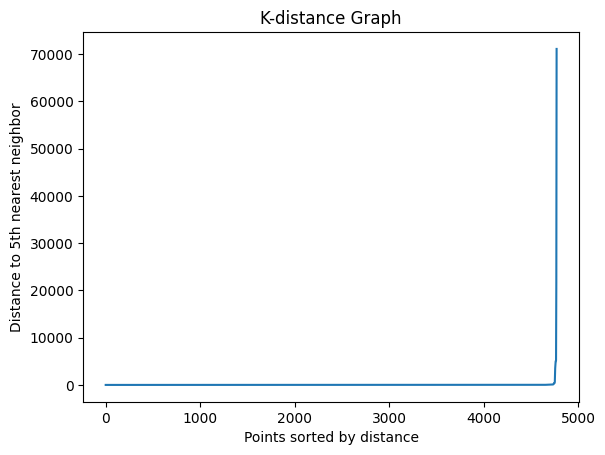

Recommended eps value: 5136.419921875


In [12]:
# The goal of this part of the code is try to find the appropriate eps
# This extract the amtcr column
targeted_column = df_filtered[['amtcr']]

# Fit nearest neighbors
min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(targeted_column)
distances, indices = neighbors_fit.kneighbors(targeted_column)

# Sort distances and plot
distances = np.sort(distances[:, -1], axis=0)
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to {}th nearest neighbor'.format(min_samples))
plt.show()

# Convex upwards and give me where the k-distance increases the most
kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing') 
recommended_eps = distances[kneedle.knee]  # This gives the optimal eps value

print(f"Recommended eps value: {recommended_eps}")

In [13]:
# Initialize DBSCAN
dbscan = DBSCAN(eps=recommended_eps , min_samples=5)  # Adjust as needed

# Fit the model
dbscan.fit(targeted_column)

# Get the labels (cluster assignments)
labels = dbscan.labels_

# Assign the score
df_filtered['cluster'] = labels

# Identify anomalies
anomalies = df_filtered[df_filtered['cluster'] == -1]

print(anomalies)

                                   date  year  month  brnid        brnmisc7  \
brnid fdb_commonname                                                          
200   Employee Benefits 394  2023-12-31  2023     12    200  Corporate LATC   
                        395  2023-12-31  2023     12    200  Corporate LATC   
                        396  2023-12-31  2023     12    200  Corporate LATC   
                        3361 2024-06-30  2024      6    200  Corporate LATC   

                             department    altdept     type typ_text  \
brnid fdb_commonname                                                   
200   Employee Benefits 394   Corporate  Corporate  Expense  Expense   
                        395   Corporate  Corporate  Expense  Expense   
                        396   Corporate  Corporate  Expense  Expense   
                        3361  Corporate  Corporate  Expense  Expense   

                               category        subcategory     fdb_commonname  \
brnid fdb_c

## General DBSCAN Algorithm

In [14]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="kneed.knee_locator")


In [15]:
# List to store all anomalies
all_anomalies = []
min_samples = 5
# Iterate through each unique combination of brnid and fdb_commonname
for _, row in combination_check.iterrows():
    brnid_value = row['brnid']
    fdb_commonname_value = row['fdb_commonname']
    
    # Filter the data for this specific combination
    df_filtered = grouped_df_1[(grouped_df_1['brnid'] == brnid_value) & 
                               (grouped_df_1['fdb_commonname'] == fdb_commonname_value)]
    
    columns = ['amtdb', 'amtcr', 'amtbalance']
    
    # Initialize anomaly columns in df_filtered to ensure they exist
    for column in columns:
        anomaly_column = f'{column} Anomaly'
        df_filtered[anomaly_column] = np.nan
        
    # Apply DBSCAN for each column
    for column in columns:
        # Extract the target column for DBSCAN
        targeted_column = df_filtered[[column]]
        
        # Ensure there are enough data points to apply DBSCAN, no worry in our case 
        if len(targeted_column) >= min_samples:
            #TRY TO FIND THE BEST eps
            # Fit nearest neighbors for K-distance graph 
            neighbors = NearestNeighbors(n_neighbors=min_samples)
            neighbors_fit = neighbors.fit(targeted_column)
            distances, indices = neighbors_fit.kneighbors(targeted_column)

            # Sort distances and find the knee point
            distances = np.sort(distances[:, -1], axis=0)

            # Use Kneedle to detect the elbow point (optimal eps)
            kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
            # Check if kneedle found a knee; if not, set a default value for eps
            if kneedle.knee is not None:
                recommended_eps = distances[kneedle.knee]
            else:
                recommended_eps = 0.5  
            if recommended_eps == 0.0:
                recommended_eps = 0.5  # Default is 0.5

            #DBSCAN USING recommended_eps
            # Initialize and fit DBSCAN
            dbscan = DBSCAN(eps=recommended_eps, min_samples=min_samples)
            dbscan.fit(targeted_column)
            
            # Get score
            labels = dbscan.labels_
            anomaly_column = f'{column} Anomaly'  
            df_filtered[anomaly_column] = labels
        
    # If any of the three columns has an anomaly (-1), add the row to the result
    result_filtered_detection = df_filtered[
        (df_filtered['amtdb Anomaly'] == -1) |
        (df_filtered['amtcr Anomaly'] == -1) |
        (df_filtered['amtbalance Anomaly'] == -1)
    ].reset_index(drop=True)
    
    # Append the result to the list of all anomalies
    if not result_filtered_detection.empty:
        all_anomalies.append(result_filtered_detection)

# Combine all results into a single DataFrame
combined_anomalies_df = pd.concat(all_anomalies, ignore_index=True)

print("Combined anomalies DataFrame:")
print(combined_anomalies_df)


Combined anomalies DataFrame:
           date  year  month  brnid          brnmisc7        department  \
0    2023-01-31  2023      1    200    Corporate LATC         Corporate   
1    2024-04-30  2024      4    200    Corporate LATC         Corporate   
2    2024-04-30  2024      4    200    Corporate LATC         Corporate   
3    2023-12-31  2023     12    200    Corporate LATC         Corporate   
4    2023-12-31  2023     12    200    Corporate LATC         Corporate   
...         ...   ...    ...    ...               ...               ...   
4812 2024-01-31  2024      1    510  Great Dane (510)  Used Truck Sales   
4813 2024-01-31  2024      1    510  Great Dane (510)   New Truck Sales   
4814 2023-03-31  2023      3    510  Great Dane (510)  Used Truck Sales   
4815 2023-03-31  2023      3    510  Great Dane (510)  Used Truck Sales   
4816 2023-02-28  2023      2    510  Great Dane (510)  Used Truck Sales   

               altdept     type typ_text    category  \
0            

In [16]:
# Filter and group for 'amtdb Anomaly'
amtdb_anomaly_df = combined_anomalies_df[combined_anomalies_df['amtdb Anomaly'] == -1].reset_index(drop=True)
print("AMTDB Anomaly DataFrame shape:", amtdb_anomaly_df.shape)
grouped_counts_amtdb = amtdb_anomaly_df.groupby(['year', 'month']).size().reset_index(name='count')
print("Grouped Counts for AMTDB Anomaly:")
print(grouped_counts_amtdb)

# Filter and group for 'amtcr Anomaly'
amtcr_anomaly_df = combined_anomalies_df[combined_anomalies_df['amtcr Anomaly'] == -1].reset_index(drop=True)
print("AMTCR Anomaly DataFrame shape:", amtcr_anomaly_df.shape)
grouped_counts_amtcr = amtcr_anomaly_df.groupby(['year', 'month']).size().reset_index(name='count')
print("Grouped Counts for AMTCR Anomaly:")
print(grouped_counts_amtcr)

# Filter and group for 'amtbalance Anomaly'
amtbalance_anomaly_df = combined_anomalies_df[combined_anomalies_df['amtbalance Anomaly'] == -1].reset_index(drop=True)
print("AMTBALANCE Anomaly DataFrame shape:", amtbalance_anomaly_df.shape)
grouped_counts_amtbalance = amtbalance_anomaly_df.groupby(['year', 'month']).size().reset_index(name='count')
print("Grouped Counts for AMTBALANCE Anomaly:")
print(grouped_counts_amtbalance)

AMTDB Anomaly DataFrame shape: (2559, 18)
Grouped Counts for AMTDB Anomaly:
    year  month  count
0   2023      1    202
1   2023      2    143
2   2023      3    138
3   2023      4    138
4   2023      5    116
5   2023      6    115
6   2023      7     91
7   2023      8    128
8   2023      9     96
9   2023     10    101
10  2023     11    129
11  2023     12     93
12  2024      1    159
13  2024      2    181
14  2024      3    158
15  2024      4    160
16  2024      5    208
17  2024      6    203
AMTCR Anomaly DataFrame shape: (2205, 18)
Grouped Counts for AMTCR Anomaly:
    year  month  count
0   2023      1     81
1   2023      2    137
2   2023      3    173
3   2023      4     94
4   2023      5     64
5   2023      6     82
6   2023      7     49
7   2023      8     66
8   2023      9     66
9   2023     10     73
10  2023     11     66
11  2023     12     49
12  2024      1    170
13  2024      2    247
14  2024      3    237
15  2024      4    170
16  2024      5    2